# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


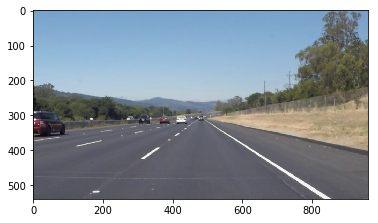

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
def readAndPlotImage(path, cmap=None):
    #reading in an image
    image = mpimg.imread(path)

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image, cmap=cmap)  
    plt.show()

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


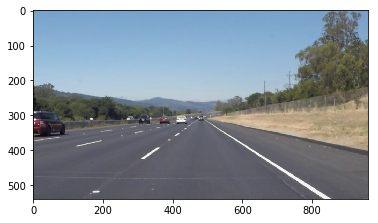

In [4]:
readAndPlotImage('test_images/solidWhiteRight.jpg')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, invert=False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are zero
    if invert:
        masked_image = cv2.bitwise_and(img, cv2.bitwise_not(mask))
        
    #returning the image only where mask pixels are nonzero
    else:
        masked_image = cv2.bitwise_and(img, mask)

    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [6]:
def hough_output(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

In [7]:
from sklearn import linear_model
import pandas as pd


def get_mask(img, inner=False):
    """
    Return mask vertices based on input image size.
    
    Vertex locations are calculated proportionally to the input image's size.
    The proportions are based on the following mask for a 540x960 image:
    
    x = np.array([480., 480., 690., 290.])
    y = np.array([340., 340., 500., 500.])
    
    INPUT:
      img - np.array
          image that will be masked. used as reference to determine dimensions of mask
      inner - boolean, [optional], default=False
          if True, returns a small mask that hides the interior of the lane
          if False, returns a mask that hides everything outside of the lane
    
    OUTPUT:
      mask - np.array (int32), [[x0, y0], ..., [xn, yn]]
    
    """
    dim = img.shape
    if inner:
        x = np.array([480., 480., 690., 290.])/960.*dim[1]
        y = np.array([340., 340., 500., 500.])/540.*dim[0]
        
    else:
        x = np.array([400., 550., 900., 120.])/960.*dim[1]
        y = np.array([335., 335., 500., 500.])/540.*dim[0]
    
    mask = np.array([[x[0], y[0]], [x[1], y[1]], [x[2], y[2]], [x[3], y[3]]], 'int32')
    return mask


def draw_new_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    Creates a new image (black background) and draws in lines of the desired color and thickness.
    
    INPUT:
      img - np.array
          reference image. only use to determine the dimensions of the output
      lines - np.array, shape = (n, 1, 4)
          location of endpoints of lines
          example: array([[[L0_x0, L0_y0, L0_x1, L0_y1]], ..., [[Ln_x0, Ln_y0, Ln_x1, Ln_y1]]])
      color - list or np.array, [optional], default=[255, 0, 0] (red)
          RGB notation for the desired line color
      thickness - int, [optional], default=2
          desired line thickness
          
    OUTPUT:
      img - np.array (same dimensions as input *img*)
          black background with solid line segments of desired *color* and *thickness* for
          each entry in *lines*
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img


def draw_lines_final(img, lines, color=[255, 0, 0], thickness=2, style='split'):
    """
    Take in set of line segments (output of extrapolate_lines). 
    Draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    The input has 3 line segments: 
        - avg line: should run through center of the lane line
        - top line: approximates location of the top lane line
        - bot line: approximates location of the bottom lane line
        
    style parameter:
      split:
          draw each line in a different color (red, green, blue)
      avg:
          only draw the avg line (in specified color)
      fill:
          polyfill between the top/bottom lines (in specified color)
    """
    if style=='split':
        for i, line in enumerate(lines):
            for x1,y1,x2,y2 in line:
                color = [0, 0, 0]
                color[i] = 255
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
    elif style=='avg':
        if lines.shape[0] > 0:
            for x1,y1,x2,y2 in lines[0]:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    elif style=='fill':
        if lines.shape[0] > 0:
            for x1,y1,x2,y2 in lines[0]:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def describe_lines(lines, y_top=310, y_bot=540):
    """
    Take in set of line segments (output of extrapolate_lines). 
    Output pandas dataframe with descriptive stats for each line.
    
    INPUT:
      lines - np.array, shape = (n, 1, 4)
          location of endpoints of lines
          example: array([[[L0_x0, L0_y0, L0_x1, L0_y1]], ..., [[Ln_x0, Ln_y0, Ln_x1, Ln_y1]]])
      y_top - int, [optional], default=310
          y-coordinate of top of mask
      y_bot - int, [optional], default=540
          y-coordinate of bottom of mask
          
    OUTPUT:
      df_lines - pd.DataFrame, shape = (n, 8)
          columns:
            slope - slope of the line segment
            weight - length of the line segment
            int_bot - x-intercept at y=y_bot
            int_top - x-intercept at y=y_top
            x1 - x-coordinate of line segment start
            y1 - y-coordinate of line segment start
            x2 - x-coordinate of line segment end
            y2 - y-coordinate of line segment end
    """
    slope = []
    l = []
    interc1 = []
    interc2 = []

    for i, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            slope += [np.round(m*180/np.pi, 0)]
            l += [np.sqrt((y2-y1)**2 + (x2-x1)**2)]
            # x intercept at bottom of image (y=540)
            interc1 += [np.round((y_bot-y1)/m + x1, 0)]
            # x intercept at top of image (y=310)
            interc2 += [np.round((y_top-y1)/m + x1, 0)]

    df_lines = pd.DataFrame({'slope': slope, 'weight': l, 'int_bot': interc1, 'int_top': interc2,
                             'x1': lines[:, :, 0].flatten(),
                             'y1': lines[:, :, 1].flatten(),
                             'x2': lines[:, :, 2].flatten(),
                             'y2': lines[:, :, 3].flatten(),})
    return df_lines


def filter_lines(df_lines, min_bot=0, max_bot=960, min_top=100, max_top=800):
    """
    Filter df_lines to exclude extreme x-intercepts.
    
    INPUT:
      df_lines - pd.DataFrame, output of describe_lines()
      min_bot - int, [optional], default=0
          minimum x-coordinate where line can intercept bottom of mask
      max_bot - int, [optional], default=960
          maximum x-coordinate where line can intercept bottom of mask
      min_top - int, [optional], default=100
          minimum x-coordinate where line can intercept top of mask
      max_top - int, [optional], default=800
          maximum x-coordinate where line can intercept top of mask
          
    OUTPUT:
      candidates - pd.DataFrame
          filtered version of df_lines, such that any line segments who's x-intercepts fall outside
          of the desired range are excluded. the filtered dataset is also sorted by descending 'x1' values
    """
    candidates = df_lines[(df_lines.int_bot > min_bot) & (df_lines.int_bot < max_bot) &
                          (df_lines.int_top > min_top) & (df_lines.int_top < max_top)]\
        .sort_values('x1').reset_index(drop=True)
    return candidates


def line_coord(df_lines):
    """Helper function that returns coordinates of line segments in df_lines as an array."""
    return df_lines[['x1', 'y1', 'x2', 'y2']].values.reshape(-1, 1, 4)


def extrapolate_lines(line_img, style='avg', huber=False):
    """
    Given an image, calculate a best-fit line using all non-black pixels.
    Return the resulting line segment(s), with y_values set to the top
    and bottom of the image mask.
    
    INPUT: 
      line_img - np.array, image whose pixels we want to fit a line to
      style - string, [optional], default='avg'
          'avg': fit a single line to all points
          else: return set of three best fit lines:
              [0] - a best-fit line based on all points
              [1] - a best-fit line based on all points to the left of [0]
              [2] - a best-fit line based on all points to the right of [0]
      huber - boolean, [optional], default=False
          if true, use linear_model.HuberRegressor(
                  fit_intercept=True, alpha=0.0, max_iter=100, epsilon=1.5)
          if false, use linear_model.LinearRegression()
          
    OUTPUT:
      np.array([
            [[x_lineAVG[0], y_mask[0], x_lineAVG[1], y_mask[1]]],
            [[x_lineTOP[0], y_mask[0], x_lineTOP[1], y_mask[1]]],
            [[x_lineBOT[0], y_mask[0], x_lineBOT[1], y_mask[1]]],
        ])
        
      NOTE: if style='avg', only the first row of the output array is returned.
      
    """
    if line_img.sum() < 1:
        return np.array([])
    
    mask = get_mask(line_img)

    # grab the red x and y coordinates (the location of all line pixels)
    y_raw, x_raw, _ = np.where(line_img>200)
    y_raw = y_raw.reshape(-1, 1)
    x_raw = x_raw.reshape(-1, 1)
    
    # fit a linear regression to all pixels
    if huber:
        lm = linear_model.HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,
                                         epsilon=1.5)
    else:
        lm = linear_model.LinearRegression()

    lm_avg = lm.fit(y_raw, x_raw)
    y_line = np.array([[mask[0, 1]], [mask[-1, 1]]]).reshape(-1, 1)
    x_lineAVG = lm_avg.predict(y_line).astype(int)

    if style == 'avg':
        return np.array([[[x_lineAVG[0], y_line[0], x_lineAVG[1], y_line[1]]]])
        
    else:
        # compare raw points to the predicted values - split into 2 groups:
        #    pixels above or below the regression line
        x_pred = lm_avg.predict(y_raw).reshape(-1, 1)
        x_top = np.extract(x_raw >= x_pred, x_raw).reshape(-1, 1)
        y_top = np.extract(x_raw >= x_pred, y_raw).reshape(-1, 1)
        x_bot = np.extract(x_raw < x_pred, x_raw).reshape(-1, 1)
        y_bot = np.extract(x_raw < x_pred, y_raw).reshape(-1, 1)

        # fit a separate regression to the top pixels
        lm_top = lm.fit(y_top, x_top)
        x_lineTOP = lm_top.predict(y_line).astype(int)

        # fit a separate regression to the bottom pixels
        lm_bot = lm.fit(y_bot, x_bot)
        x_lineBOT = lm_bot.predict(y_line).astype(int)

        extrapolated_lines = np.array([
            [[x_lineAVG[0], y_line[0], x_lineAVG[1], y_line[1]]],
            [[x_lineTOP[0], y_line[0], x_lineTOP[1], y_line[1]]],
            [[x_lineBOT[0], y_line[0], x_lineBOT[1], y_line[1]]],
        ])
    
        return extrapolated_lines

            
def hough_lines2(img, rho, theta, threshold, min_line_len, max_line_gap, 
                 style='avg', color=[255, 0, 0], extrapolate=True,
                 colormask=None, colormask_weight=1, huber=True,
                 thickness=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # get slope and extrapolated intercepts of each line segment
    df_lines = describe_lines(lines)
    # filter for lines that roughly fit within the mask 
    # (NOTE: this will also exclude any roughly horizontal lines!!!)
    df_filt = filter_lines(df_lines, max_bot=img.shape[1], min_top=0.1*img.shape[1], max_top=0.8*img.shape[1])
    
    left_raw = line_coord(df_filt[df_filt.slope < 0])
    right_raw = line_coord(df_filt[df_filt.slope >= 0])
    
    # split line segments into two halves: negative slope and positive slope
    if extrapolate:
        left_img = draw_new_lines(img, left_raw)
        right_img = draw_new_lines(img, right_raw)
        
        # if a colormask was provided, calculate the split lane lines based on the raw colormask
        # and draw a 1-pt wide line on the input to the line extrapolation data
        if (colormask is not None):
            _, split_left, split_right = lane_lines_split(colormask, style=style)
            draw_lines(left_img, split_left, thickness=colormask_weight)
            draw_lines(right_img, split_right, thickness=colormask_weight)
        
        left_lines = extrapolate_lines(left_img, style=style, huber=huber)
        right_lines = extrapolate_lines(right_img, style=style, huber=huber)
    else:
        left_lines = left_raw
        right_lines = right_raw
    
    # draw the lines on a blank image:
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_final(line_img, left_lines, style=style, color=color, thickness=thickness)
    draw_lines_final(line_img, right_lines, style=style, color=color, thickness=thickness)

    return line_img

            
def lane_lines_split(img, color=[255, 0, 0], style='avg', huber=True, thickness=10):
    """
    Returns a black image with best fit lane lines drawn in desired color.
    Input image is split in half before fitting separate best fit lines to the 
    right and left halves of the image.
    
    INPUT:
      img - np.array, shape=(x, y, 1) -- single color channel!!
          should be a single color channel image, like the output of yellow/white thresholding
          best fit lines will be generated based on non-black pixels of this image.
      color - list or array, [optional] default = [255, 0, 0] (red)
          color to draw best-fit lines (ignored if style='split')
      style - string, [optional], default = 'avg'
          'avg' = draw a single best fit line for right and left sides of the image
          'split' = draw three lines for each side of image:
              green - left best fit line
              red - center best fit line
              blue - right best fit line
          'fill' = draw three lines for each side of image (all in same color)
      huber - boolean, [optional], default=True
          Describes what type of linear model to use for best fit lines
          if True, use linear_model.HuberRegressor()
          if False, use linear_model.LinearRegression()
      thickness - int, [optional], default=10
          Thickness of drawn lines.
              
    OUTPUT:
      np.array, shape=(x, y, 3)
          black image with best fit lane lines drawn in desired color
    
    """
    
    mask = get_mask(img)
    
    x_split = int(np.mean([mask[0, 0], mask[1, 0]]))
    
    left_img = np.copy(img)
    left_img[:, x_split:] = 0
    
    right_img = np.copy(img)
    right_img[:, :x_split] = 0
    
    left_lines = extrapolate_lines(cv2.cvtColor(left_img, cv2.COLOR_GRAY2RGB), style=style, huber=huber)
    right_lines = extrapolate_lines(cv2.cvtColor(right_img, cv2.COLOR_GRAY2RGB), style=style, huber=huber)
    
    # draw the lines on a blank image:
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_final(line_img, left_lines, style=style, color=color, thickness=thickness)
    draw_lines_final(line_img, right_lines, style=style, color=color, thickness=thickness)

    return line_img, left_lines, right_lines


def apply_mask(image):
    """
    Helper function that returns masked version of the input image.
    """
    mask = get_mask(image)
    masked_out = region_of_interest(image, [mask])
    
#     mask_inner = get_mask(image, inner=True)
#     masked_img = region_of_interest(masked_out, [mask_inner], invert=True)
    
    return masked_out

In [8]:
def highlight_hsl(img, color='white'):
    """
    Return single-channel image that highlights location of pixels within given color thresholds.
    
    INPUT:
      img - np.array, RGB image to be filtered using HSL thresholds.
      color - string, [optional], default='white'
          Specify which HSL band to filter on:
          'white' =  low: [0,  200,  0]; high: [255, 255, 255]
          'yellow' = low: [20, 120, 80]; high: [45,  200, 255]
    """
    # convert to hsl
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS);

    # threshold on color
    if color == 'white':
        mask = cv2.inRange(hls_img, np.array([0, 200, 0]), np.array([255, 255, 255]))
    elif color == 'yellow':
        mask = cv2.inRange(hls_img, np.array([20, 120, 80]), np.array([45, 200, 255]))
    
    return mask

In [9]:
def extract_white_yellow(image):
    """Return single-channel version of image, with only white&yellow pixels turned on."""
    # superimpose yellow pixels (as a white mask) on top of original image
    mask_y = highlight_hsl(image, color='yellow')
    # superimpose white pixels (as a white mask) on top of original image
    mask_w = highlight_hsl(image, color='white')
    
    # combine yellow & white masks 
    # (no need to convert to grayscale -- already a single channel image):
    wy_img = cv2.bitwise_or(mask_y, mask_w)
    
    return wy_img

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


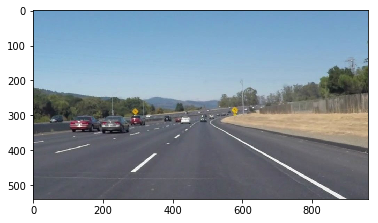

solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


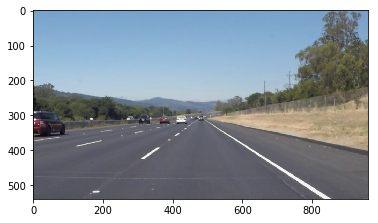

solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


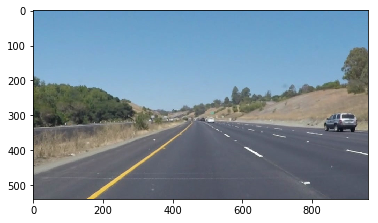

solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


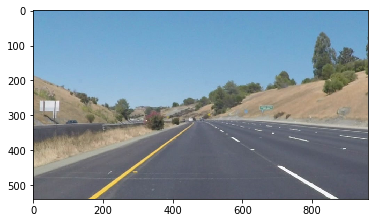

solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


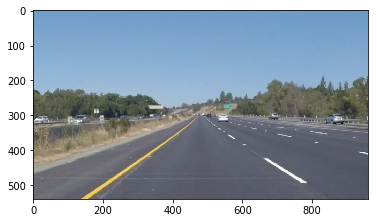

whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


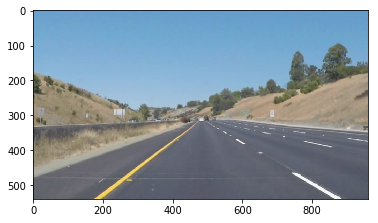

In [11]:
for f in os.listdir("test_images/"):
    if '.jpg' in f:
        print(f)
        readAndPlotImage('test_images/%s' % f)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

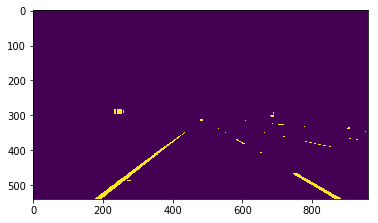

In [12]:
# plot white yellow mask
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
wy_img = extract_white_yellow(image)
plt.imshow(wy_img)  
plt.show()
mpimg.imsave('writeup/wy.jpg', wy_img)

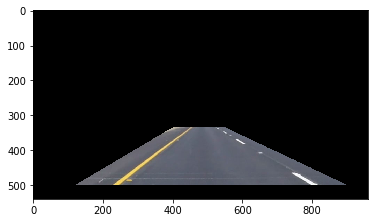

In [13]:
# Plot mask on original image
mask_img = apply_mask(image)
plt.imshow(mask_img)  
plt.show()
mpimg.imsave('writeup/mask.jpg', mask_img)

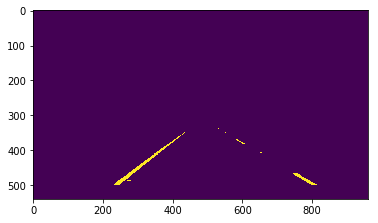

In [14]:
# plot mask on white/yellow pixels
mask_wy = apply_mask(wy_img)
plt.imshow(mask_wy)  
plt.show()
mpimg.imsave('writeup/mask_wy.jpg', mask_wy)

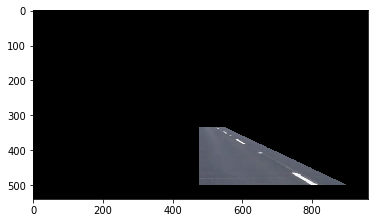

In [15]:
# split image in half
mask = get_mask(image)
x_split = int(np.mean([mask[0, 0], mask[1, 0]]))

right_img = np.copy(mask_img)
right_img[:, :x_split] = 0

plt.imshow(right_img)  
plt.show()
mpimg.imsave('writeup/right_mask.jpg', right_img)

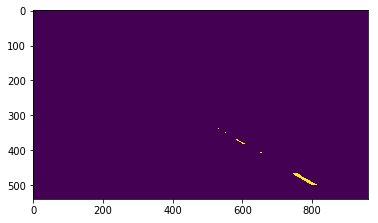

In [16]:
# split white/yellow pixels in half
mask = get_mask(image)
x_split = int(np.mean([mask[0, 0], mask[1, 0]]))

right_wy = np.copy(mask_wy)
right_wy[:, :x_split] = 0

plt.imshow(right_wy)  
plt.show()
mpimg.imsave('writeup/right_mask_wy.jpg', right_wy)

/Users/tbackes/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


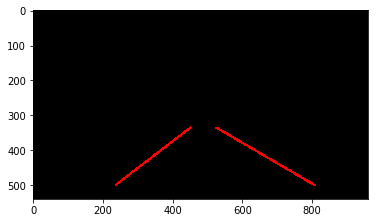

In [17]:
# best fit lines
line_seg, _, _ = lane_lines_split(mask_wy, huber=True, thickness=5)

plt.imshow(line_seg)  
plt.show()
mpimg.imsave('writeup/line_huber.jpg', line_seg)

/Users/tbackes/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


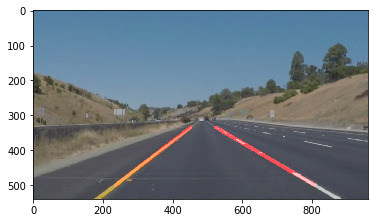

In [18]:
# best fit lines on original image
line_seg_Final, _, _ = lane_lines_split(mask_wy, huber=True, thickness=10)
result = weighted_img(line_seg_Final, image)

plt.imshow(result)  
plt.show()
mpimg.imsave('writeup/final_lane_lines.jpg', result)

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
get_mask(image)

array([[400, 335],
       [550, 335],
       [900, 500],
       [120, 500]], dtype=int32)

In [22]:
def process_image(image):
    """
    Detect lanes lines from white and yellow pixels in image.
    
    Assumes there are two lanes on left and right of image, and splits
    image down the middle to detect them.
    
    OUTPUT: Estimate of lane lines (red) superimposed on original image.
    """
    # superimpose yellow pixels (as a white mask) on top of original image
    mask_y = highlight_hsl(image, color='yellow')
    # superimpose white pixels (as a white mask) on top of original image
    mask_w = highlight_hsl(image, color='white')
    
    # combine yellow & white masks 
    # (no need to convert to grayscale -- already a single channel image):
    wy_img = cv2.bitwise_or(mask_y, mask_w)
    
    # mask the image (restrict to trapezoidal "region of interest")
    masked_img = apply_mask(wy_img)
    
    # detect lane lines directly from pixels
    line_seg, _, _ = lane_lines_split(masked_img, huber=True)

    # superimpose lane lines onto original image
    result = weighted_img(line_seg, image)
  
    return result

Let's try the one with the solid white lane on the right first ...

In [23]:
white_output = 'test_videos_output/solidWhiteRight_final.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time 
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_final.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_final.mp4


100%|█████████▉| 221/222 [00:11<00:00, 19.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_final.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
yellow_output = 'test_videos_output/solidYellowLeft_final.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')#.subclip(0,0.1)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_final.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_final.mp4


100%|█████████▉| 681/682 [00:35<00:00, 18.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_final.mp4 

CPU times: user 40.2 s, sys: 6.57 s, total: 46.8 s
Wall time: 35.7 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.

Here is a [link](https://github.com/tbackes/CarND-LaneLines-P1/blob/master/writeup.md) to my final writeup.



## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [27]:
challenge_output = 'test_videos_output/challenge_final.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(5.5, 6.5)
clip3 = VideoFileClip('test_videos/challenge.mp4')#.subclip(0,0.1)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_final.mp4
[MoviePy] Writing video test_videos_output/challenge_final.mp4


100%|██████████| 251/251 [00:20<00:00, 12.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_final.mp4 

CPU times: user 23.4 s, sys: 2.92 s, total: 26.3 s
Wall time: 21.2 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))